<a href="https://colab.research.google.com/github/PGV1000/data_mining/blob/main/%D0%9C%D0%B5%D0%B4%D0%B2%D0%B5%D0%B4%D0%B5%D0%B2_%D0%9F%D0%A0_%E2%84%965_Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №5. Random forest**

# Задание 1. Обучите классификатор Random Forest для решения задачи бинарной классификации: для каждого человека научиться предсказывать, выживет ли он при крушении Титаника.

Ссылка на датасет: https://www.kaggle.com/c/titanic/data

## 1. Устанавливаем зависимости

In [46]:
%%capture
!pip install category_encoders

In [66]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix

## 2. Импортируем датасет

In [48]:
# Загружаем датасет из гугл-диска
datadir = 'titanic' # Папка с датасетом
if os.path.isdir(datadir)>0: # Если папка уже есть, то ничего не скачиваем
    print ('Data directory already exists and it is not empty, miss downloading')
else: # Иначе скачиваем и распаковываем
    print ('Data directory does not exists or it is empty, download the dataset')
    !gdown --id 1L9zUaNCNKQCXZiwa20MPoMetapRHTvCI #Скопировать ID из ссылки на файл в гугл диске, предварительно нужно открыть доступ по ссылке.
    !unzip titanic.zip # Распаковка архива

Data directory already exists and it is not empty, miss downloading


## 3. Производим разведовательный анализ данных


Получим представление о данных в датасете:

In [49]:
df = pd.read_csv('/content/titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 4. Сформируем обучающую и тестовую выборки:


In [51]:
x = df.drop(['Survived', 'Name', 'PassengerId', 'Ticket', 'Fare'], axis=1)
y = df['Survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 1)
x_train.shape, x_test.shape

((596, 7), (295, 7))

## 5. Feature Engineering

Поработаем с признаками, выделим важные, изменим форму их представления (при надобности)

In [52]:
x_train.dtypes

,0
Pclass,int64
Sex,object
Age,float64
SibSp,int64
Parch,int64
Cabin,object
Embarked,object


In [53]:
x_train.head()

,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
496,1,female,54.0,1,0,D20,C
14,3,female,14.0,0,0,NaN,S
82,3,female,NaN,0,0,NaN,Q
657,3,female,32.0,1,1,NaN,Q
388,3,male,NaN,0,0,NaN,Q


In [54]:
encoder = ce.OrdinalEncoder(cols=['Sex', 'Cabin', 'Embarked'])
x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)
x_train.head(10)

,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
496,1,1,54.0,1,0,1,1
14,3,1,14.0,0,0,105,2
82,3,1,NaN,0,0,105,3
657,3,1,32.0,1,1,105,3
388,3,2,NaN,0,0,105,3
88,1,1,23.0,3,2,2,2
273,1,2,37.0,0,1,3,1
172,3,1,1.0,1,1,105,2
474,3,1,22.0,0,0,105,2
103,3,2,33.0,0,0,105,2


In [55]:
x_test.head()

,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
862,1,1,48.0,0,0,-1.0,2
223,3,2,NaN,0,0,105.0,2
84,2,1,17.0,0,0,105.0,2
680,3,1,NaN,0,0,105.0,3
535,2,1,7.0,0,2,105.0,2


In [56]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
feature_scores = pd.Series(rfc.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_scores

,0
Sex,0.312357
Age,0.301729
Cabin,0.118244
Pclass,0.098860
SibSp,0.071551
Embarked,0.048688
Parch,0.048571


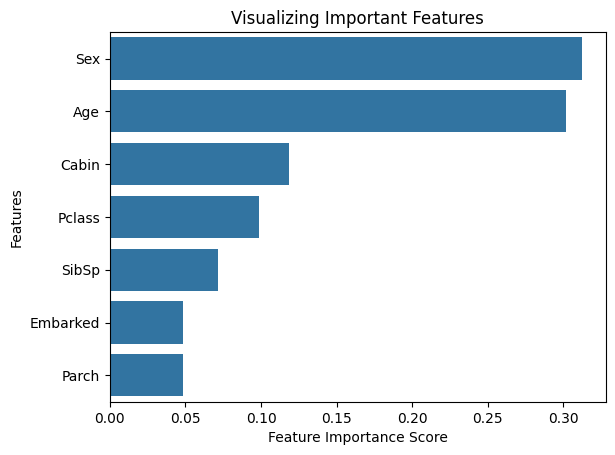

In [57]:
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## 6. Построение базовой модели:

In [58]:
rfc = RandomForestClassifier(n_estimators=8, random_state=1)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

## 7. Оценка точности модели:

### 7.1. Напишите функцию, принимающую на вход аргументы y_pred, y_test и выполняющую визуализацию матрицы ошибок и отчета классификации

In [59]:
def count_metrics(test, prediction):
  cm = confusion_matrix(test, prediction)
  plt.figure(figsize=(10, 10))
  sns.heatmap(cm, annot=True, fmt =".0f",  cmap='Blues')
  plt.xlabel('Prediction')
  plt.ylabel('GT')
  plt.show()
  print(classification_report(test, prediction))

### 7.2. Оцените точность модели:

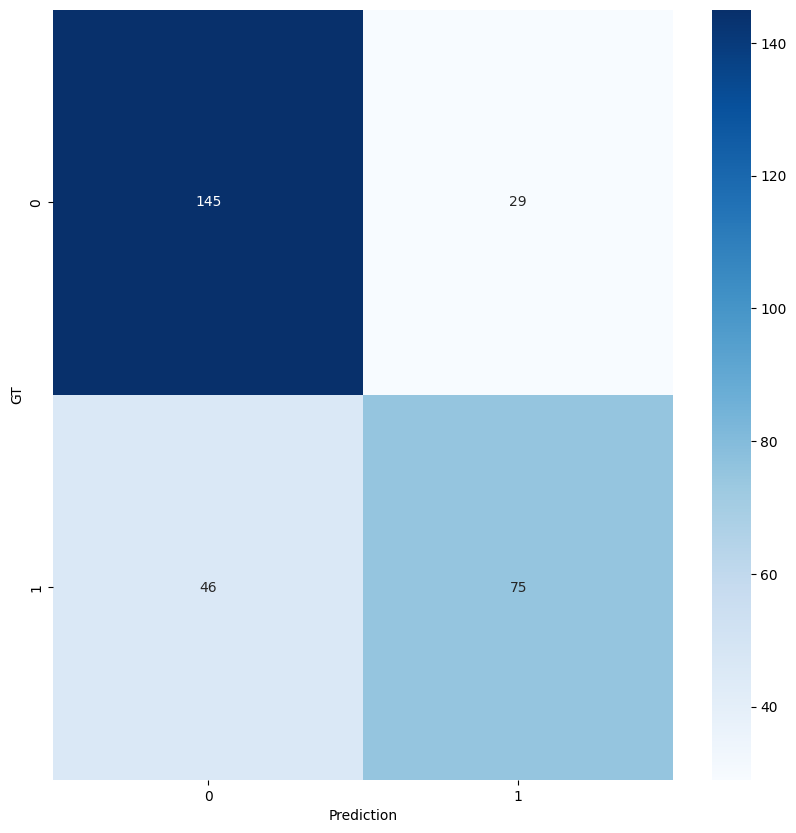

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       174
           1       0.72      0.62      0.67       121

    accuracy                           0.75       295
   macro avg       0.74      0.73      0.73       295
weighted avg       0.74      0.75      0.74       295



In [60]:
y_pred = rfc.predict(x_test)
count_metrics(y_test, y_pred)

## 8. Тюнинг гиперпараметров модели:

RandomSearchCV

In [80]:
warnings.filterwarnings('ignore')
n_estimators = [int(x) for x in np.linspace(start=8, stop=100, num=50)]
max_depth = [int(x) for x in np.linspace(1, 100, num=50)]
max_depth.append(None)
max_leaf_nodes = [int(i) for i in range(1, 100)]
random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
}
rfc = RandomForestClassifier(random_state=1)
rfc_rs = RandomizedSearchCV(
    estimator=rfc,                # модель для настройки
    param_distributions=random_grid, # словарь с параметрами для случайного поиска
    n_iter=100,                      # количество итераций (случайных наборов гиперпараметров)
    scoring='accuracy',              # метрика для оценки качества моделей
    cv=5,                            # количество фолдов для кросс-валидации
    verbose=1,                       # уровень детализации вывода
    random_state=1,                 # фиксированный сид для воспроизводимости результатов
    n_jobs=-1                        # использование всех доступных ядер процессора
)
rfc_rs.fit(x_train, y_train)
rfc_rs_best_params = rfc_rs.best_params_
rfc_rs_best_score = rfc_rs.best_score_
print(f"Лучшие параметры: {rfc_rs_best_params}")
print(f'Лучшая точность: {rfc_rs_best_score}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Лучшие параметры: {'n_estimators': 21, 'max_leaf_nodes': 12, 'max_depth': 21}
Лучшая точность: 0.8423249299719888


GridSearchCV

In [62]:
rfc = RandomForestClassifier(random_state=1)
rfc_gs = GridSearchCV(
    estimator=rfc,                # модель для настройки
    param_grid=random_grid, # словарь с параметрами для случайного поиска
    scoring='accuracy',              # метрика для оценки качества моделей
    cv=2,                            # количество фолдов для кросс-валидации
    verbose=1,                       # уровень детализации вывода
    n_jobs=-1                        # использование всех доступных ядер процессора
)
rfc_gs.fit(x_train, y_train)
rfc_gs_best_params = rfc_gs.best_params_
rfc_gs_best_score = rfc_gs.best_score_
print(f"Лучшие параметры: {rfc_gs_best_params}")
print(f"Лучшая точность: {rfc_gs_best_score}")

Fitting 2 folds for each of 5940 candidates, totalling 11880 fits
Лучшие параметры: {'max_depth': 25, 'max_leaf_nodes': 12, 'n_estimators': 28}
Лучшая точность: 0.8523489932885906


## 9. Оценка лучшей модели:

Оценка точности базовой модели: 0.7831


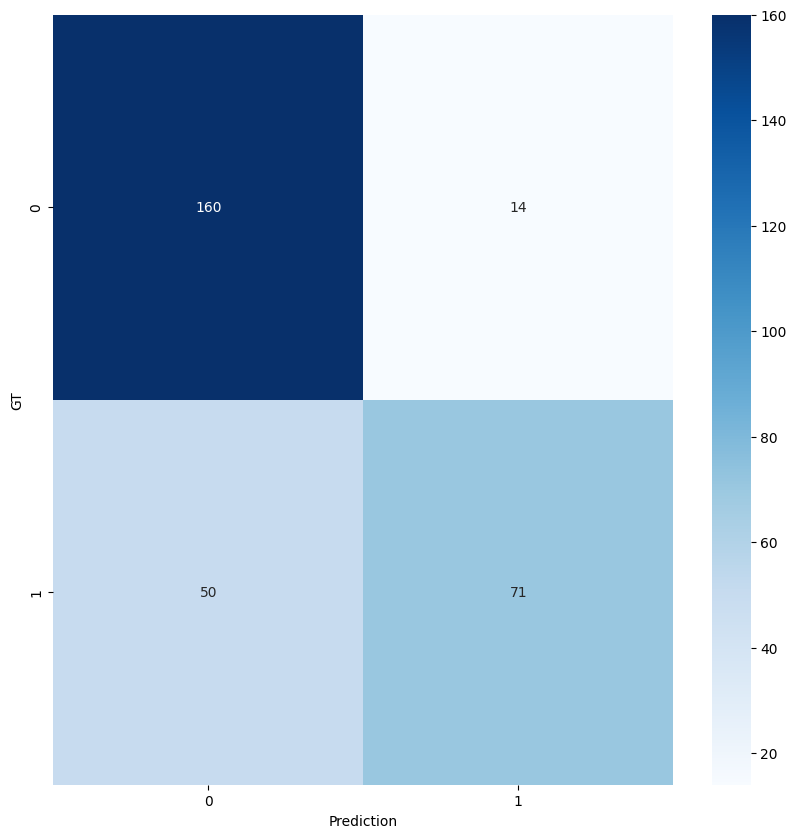

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       174
           1       0.84      0.59      0.69       121

    accuracy                           0.78       295
   macro avg       0.80      0.75      0.76       295
weighted avg       0.79      0.78      0.77       295



In [63]:
rfc_best = RandomForestClassifier(n_estimators=28, max_depth=25, max_leaf_nodes=12)
rfc_best.fit(x_train, y_train)
y_pred = rfc_best.predict(x_test)
print('Оценка точности базовой модели: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
count_metrics(y_test, y_pred)

# Задание 2. Решите задачу из предыдущего пункта используя другие, ранее пройденные классификаторы. Сравните их точность предсказания с Random Forest

In [74]:
warnings.filterwarnings('ignore')
max_depth = [int(x) for x in np.linspace(start=1, stop=100, num=50)]
max_features = [int(x) for x in np.linspace(1, 100, num=50)]
max_depth.append(None)
random_grid = {
    'max_depth': max_depth,
    'max_features': max_features
}
dtc = DecisionTreeClassifier(random_state=1)
dtc_rs = RandomizedSearchCV(
    estimator=dtc,                # модель для настройки
    param_distributions=random_grid, # словарь с параметрами для случайного поиска
    n_iter=50,                      # количество итераций (случайных наборов гиперпараметров)
    scoring='accuracy',              # метрика для оценки качества моделей
    cv=5,                            # количество фолдов для кросс-валидации
    verbose=1,                       # уровень детализации вывода
    random_state=1,                 # фиксированный сид для воспроизводимости результатов
    n_jobs=-1                        # использование всех доступных ядер процессора
)
dtc_rs.fit(x_train, y_train)
dtc_rs_best_params = dtc_rs.best_params_
dtc_rs_best_score = dtc_rs.best_score_
print(f"Лучшие параметры: {dtc_rs_best_params}")
print(f'Лучшая точность: {dtc_rs_best_score}')


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'max_features': 63, 'max_depth': 3}
Лучшая точность: 0.820546218487395


Точностиь модели решающего дерева при подборе параметров с помощью RandomSearchCV: 0.7695


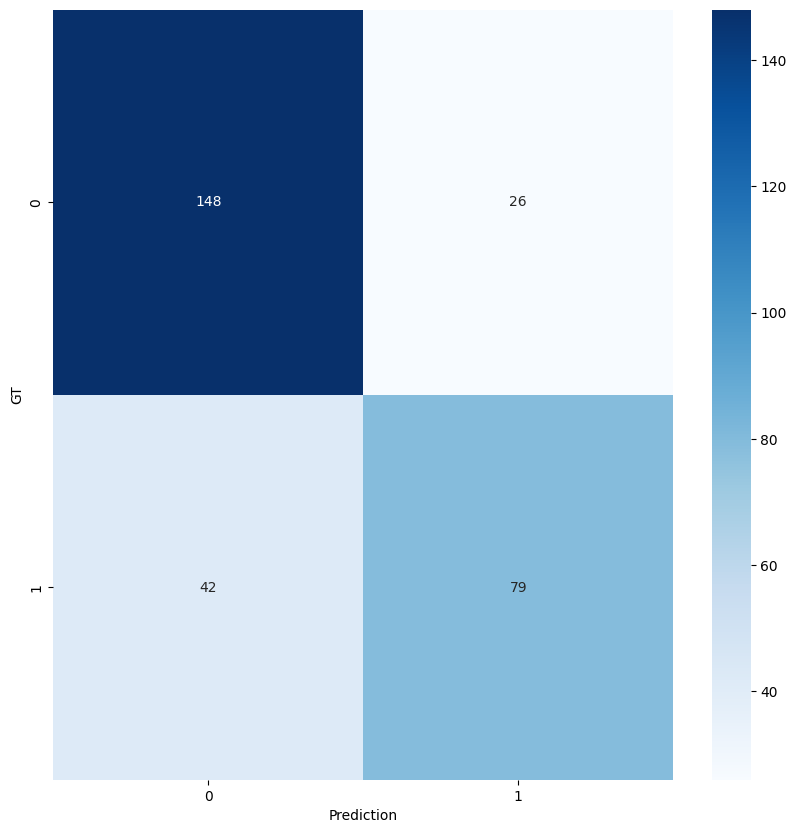

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       174
           1       0.75      0.65      0.70       121

    accuracy                           0.77       295
   macro avg       0.77      0.75      0.76       295
weighted avg       0.77      0.77      0.77       295



In [75]:
dtc_best = DecisionTreeClassifier(max_depth=3, max_features=63)
dtc_best.fit(x_train, y_train)
y_pred = dtc_best.predict(x_test)
print('Точностиь модели решающего дерева при подборе параметров с помощью RandomSearchCV: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
count_metrics(y_test, y_pred)

# Задание 2.1*. Реализуйте функцию, для взаимодействия с обученной Вами моделью

* Функция должна принимать на вход обученную модель классификатора;

* После вызова функции, у пользователя через консоль запрашиваются значения признаков. При запросе значений нужно вывести пояснения о типе и диапазоне возможных значений. Также реализуйте обработку исключений;

* После ввода значений для всех признаков в консоль, выводится результат работы классификатора.

In [84]:
y_pred = rfc_best.predict(x_test)
print(y_pred)

[1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1
 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [85]:
x_test.describe()

,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
count,295.000000,295.000000,241.000000,295.00000,295.000000,295.000000,295.000000
mean,2.281356,1.637288,28.440539,0.59661,0.406780,83.162712,1.881356
std,0.844445,0.481600,13.527895,1.22196,0.894401,41.229332,0.543507
min,1.000000,1.000000,0.420000,0.00000,0.000000,-1.000000,1.000000
25%,1.000000,1.000000,19.000000,0.00000,0.000000,105.000000,2.000000
50%,3.000000,2.000000,27.000000,0.00000,0.000000,105.000000,2.000000
75%,3.000000,2.000000,36.000000,1.00000,0.000000,105.000000,2.000000
max,3.000000,2.000000,71.000000,8.00000,6.000000,105.000000,4.000000


In [86]:
%%capture
!pip install gradio

In [87]:
import gradio as gr

In [88]:
def gradio_predict_rfc(Pclass, Sex, Age, SibSp, Parch, Cabin, Embarked):
    input_data = pd.DataFrame({
        'Pclass': [int(Pclass)],
        'Sex': [Sex],
        'Age': [float(Age)],
        'SibSp': [int(SibSp)],
        'Parch': [int(Parch)],
        'Cabin': [int(Cabin)],
        'Embarked': [Embarked]
    })
    input_encoded = encoder.transform(input_data)
    print(input_encoded)
    prediction = rfc_best.predict(input_encoded)
    if prediction == 1:
        return f"Пассажир выжил"
    else:
        return f"Пассажир не выжил"

In [89]:
iface = gr.Interface(
    fn=gradio_predict_rfc,
    inputs=[
        gr.Dropdown(choices=[1, 2, 3], label="Pclass (Класс билета)"),
        gr.Radio(choices=['male', 'female'], label="Sex (Пол)"),
        gr.Slider(minimum=0, maximum=80, step=1, label="Age (Возраст)"),
        gr.Slider(minimum=0, maximum=8, step=1, label="SibSp (Братья/Сестры/Супруги)"),
        gr.Slider(minimum=0, maximum=6, step=1, label="Parch (Родители/Дети)"),
        gr.Slider(minimum=0, maximum=300, step=1, label="Cabin (Номер каюты)"),
        gr.Dropdown(choices=['S', 'C', 'Q'], label="Embarked (Порт посадки)")
    ],
    outputs="text",
    title="Titanic Survival Predictor",
    description="Введите характеристики пассажира, чтобы предсказать, выжил ли он."
)
iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5882eaadb3b95e3e20.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Задание 3. Решите задачу регрессии, используя [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

* Для выполнения данного задания можете использовать **любой датасет**



In [123]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import category_encoders as ce
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [124]:
# Загружаем датасет
datadir = 'titanic' # Папка с датасетом
if os.path.isdir(datadir)>0:
    print ('Data directory already exists and it is not empty, miss downloading')
else:
    print ('Data directory does not exists or it is empty, download the dataset')
    !gdown --id 1L9zUaNCNKQCXZiwa20MPoMetapRHTvCI
    !unzip titanic.zip

df2 = pd.read_csv('/content/titanic/train.csv')
df2.head()

Data directory already exists and it is not empty, miss downloading


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [125]:
# Посмотрим на пропуски в 'Fare'
print(df2.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [129]:
# В качестве целевой переменной возьмём Age (регрессия)
y2 = df2['Fare']
x2 = df2.drop(['Name', 'PassengerId', 'Ticket', 'Fare'], axis=1)

In [130]:
# Посмотрим на типы данных
x2.dtypes

,0
Survived,int64
Pclass,int64
Sex,object
Age,float64
SibSp,int64
Parch,int64
Cabin,object
Embarked,object


In [131]:
# Категориальные признаки: Sex, Cabin, Embarked, Pclass (хотя Pclass - числовой, это категориальный признак категорий классов)
# Проведём кодирование:
encoder = ce.OrdinalEncoder(cols=['Sex','Cabin','Embarked'])
x2 = encoder.fit_transform(x2)
x2.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
0,0,3,1,22.0,1,0,148,1
1,1,1,2,38.0,1,0,1,2
2,1,3,2,26.0,0,0,148,1
3,1,1,2,35.0,1,0,2,1
4,0,3,1,35.0,0,0,148,1


In [132]:
# Разделим данные на обучение и тест
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=1)
x2_train.shape, x2_test.shape

((712, 8), (179, 8))

In [133]:
# Обучим базовую модель
rfr = RandomForestRegressor(random_state=1)
rfr.fit(x2_train, y2_train)

RandomForestRegressor(random_state=1)

In [134]:
# Оценим качество предсказания
y2_pred = rfr.predict(x2_test)
mse_test = mean_squared_error(y2_test, y2_pred)
r2_test = r2_score(y2_test, y2_pred)
print(f"Базовая модель:\nMSE на тесте: {mse_test:.2f}\nR2 на тесте: {r2_test:.2f}")

Базовая модель:
MSE на тесте: 2665.22
R2 на тесте: 0.29


Pclass      0.426093
Cabin       0.168332
Age         0.125218
Parch       0.108046
SibSp       0.092311
Sex         0.049811
Embarked    0.020585
Survived    0.009603
dtype: float64


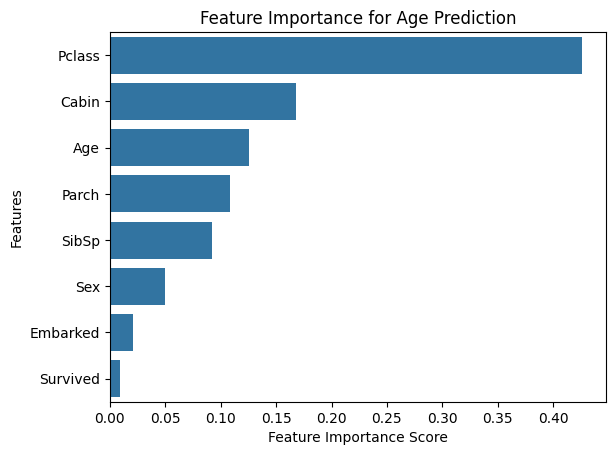

In [135]:
# Посмотрим на важность признаков
feature_scores = pd.Series(rfr.feature_importances_, index=x2_train.columns).sort_values(ascending=False)
print(feature_scores)
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance for Age Prediction")
plt.show()

In [141]:
# Подбор гиперпараметров RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start=10, stop=200, num=150)]
max_depth = [int(x) for x in np.linspace(2, 100, num=75)]
max_depth.append(None)
max_leaf_nodes = [int(i) for i in range(2, 100)]
random_grid = {
      'n_estimators': n_estimators,
      'max_depth': max_depth,
      'max_leaf_nodes': max_leaf_nodes,
}
rfr = RandomForestRegressor(random_state=1)
rfr_rs = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=random_grid,
    n_iter=100,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=1,
    n_jobs=-1
)
rfr_rs.fit(x_train, y_train)
rfr_rs_best_params = rfr_rs.best_params_
rfr_rs_best_score = rfr_rs.best_score_
print(f"Лучшие параметры (RandomizedSearchCV): {rfr_rs_best_params}")
print(f"Лучший r2_score (RandomizedSearchCV): {rfr_rs_best_score}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Лучшие параметры (RandomizedSearchCV): {'n_estimators': 129, 'max_leaf_nodes': 12, 'max_depth': 80}
Лучший r2_score (RandomizedSearchCV): 0.2566992867369175


In [147]:
# Аналогично проведём GridSearchCV, но учитывая, что параметров много, упростим сетку:
param_grid = {
    'n_estimators': [25, 50, 75, 100, 150, 175, 200],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80],
    'max_leaf_nodes': [5, 10, 15, 20]
}
rfr = RandomForestRegressor(random_state=1)
rfr_gs = GridSearchCV(
    estimator=rfr,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1
)
rfr_gs.fit(x2_train, y2_train)
rfr_gs_best_params = rfr_gs.best_params_
rfr_gs_best_score = rfr_gs.best_score_
print(f"Лучшие параметры (GridSearchCV): {rfr_gs_best_params}")
print(f"Лучший r2_score (GridSearchCV): {rfr_gs_best_score}")

Fitting 3 folds for each of 224 candidates, totalling 672 fits
Лучшие параметры (GridSearchCV): {'max_depth': 10, 'max_leaf_nodes': 5, 'n_estimators': 25}
Лучший r2_score (GridSearchCV): 0.4524911813399413


In [151]:
# Обучим модель с лучшими параметрами
rfr_rs_best = RandomForestRegressor(n_estimators=129, max_leaf_nodes=12, max_depth=80, random_state=1)
rfr_rs_best.fit(x2_train, y2_train)
y2_rs_pred_best = rfr_rs_best.predict(x2_test)
mse_rs_test_best = mean_squared_error(y2_test, y2_rs_pred_best)
r2_rs_test_best = r2_score(y2_test, y2_rs_pred_best)
print(f"Модель с подобранными параметрами (RandomizedSearchCV):\nMSE на тесте: {mse_rs_test_best:.2f}\nR2 на тесте: {r2_rs_test_best:.2f}")

Модель с подобранными параметрами (RandomizedSearchCV):
MSE на тесте: 2596.87
R2 на тесте: 0.31


In [153]:
# Обучим модель с лучшими параметрами
rfr_gs_best= RandomForestRegressor(max_depth = 10, max_leaf_nodes=5, n_estimators=25, random_state=1)
rfr_gs_best.fit(x2_train, y2_train)
y2_gs_pred_best= rfr_gs_best.predict(x2_test)
mse_gs_test_best = mean_squared_error(y2_test, y2_gs_pred_best)
r2_gs_test_best = r2_score(y2_test, y2_gs_pred_best)
print(f"Модель с подобранными параметрами (GridSearchCV):\nMSE на тесте: {mse_gs_test_best:.2f}\nR2 на тесте: {r2_gs_test_best:.2f}")

Модель с подобранными параметрами (GridSearchCV):
MSE на тесте: 2653.08
R2 на тесте: 0.29


In [171]:
def gradio_predict_rfr(Survived, Pclass, Sex, Age, SibSp, Parch, Cabin, Embarked):
    input_data = pd.DataFrame({
        'Survived': [int(Survived)],
        'Pclass': [int(Pclass)],
        'Sex': [Sex],
        'Age': [float(Age)],
        'SibSp': [int(SibSp)],
        'Parch': [int(Parch)],
        'Cabin': [Cabin],
        'Embarked': [Embarked]
    })
    input_encoded = encoder.transform(input_data)
    print(input_encoded)
    prediction = rfr_best.predict(input_encoded)
    print(prediction[0])
    return prediction[0]

In [173]:
iface = gr.Interface(
    fn=gradio_predict_rfr,
    inputs=[
        gr.Radio(choices=[1, 0], label="Survived (Выжил ли при крушении)"),
        gr.Dropdown(choices=[1, 2, 3], label="Pclass (Класс билета)"),
        gr.Radio(choices=['male', 'female'], label="Sex (Пол)"),
        gr.Slider(minimum=0, maximum=80, step=1, label="Age (Возраст)"),
        gr.Slider(minimum=0, maximum=8, step=1, label="SibSp (Братья/Сестры/Супруги)"),
        gr.Slider(minimum=0, maximum=6, step=1, label="Parch (Родители/Дети)"),
        gr.Text(label="Cabin (Номер каюты)"),
        gr.Dropdown(choices=['S', 'C', 'Q'], label="Embarked (Порт посадки)")
    ],
    outputs="number",
    title="Titanic Fare Estimator",
    description="Введите характеристики пассажира, чтобы оценить стоимость его билета."
)
iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4f35eb21c6d7f29c59.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


   Survived  Pclass  Sex   Age  SibSp  Parch  Cabin  Embarked
0         1       1    1  21.0      4      3   -1.0         1
211.59447924746496
   Survived  Pclass  Sex   Age  SibSp  Parch  Cabin  Embarked
0         1       1    2  21.0      4      3   -1.0         1
210.0411065530205
   Survived  Pclass  Sex   Age  SibSp  Parch  Cabin  Embarked
0         1       1    1  21.0      4      3   -1.0         1
211.59447924746496
   Survived  Pclass  Sex   Age  SibSp  Parch  Cabin  Embarked
0         0       1    1  21.0      4      3   -1.0         1
211.59447924746496
   Survived  Pclass  Sex   Age  SibSp  Parch  Cabin  Embarked
0         1       1    1  21.0      4      3   -1.0         1
211.59447924746496
   Survived  Pclass  Sex   Age  SibSp  Parch  Cabin  Embarked
0         1       2    1  21.0      4      3   -1.0         1
15.430859673672591
   Survived  Pclass  Sex   Age  SibSp  Parch  Cabin  Embarked
0         1       3    1  21.0      4      3   -1.0         1
15.430859673672591
